In [2]:
import os, sys, pickle
import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 
sys.path.append('/home/jp/projects/snoplus/python_modules')
import jp_mpl as jplot
from scipy import ndimage
from scipy import signal
from matplotlib.colors import LogNorm
from detect_peaks import detect_peaks
import pickle, scipy
from copy import deepcopy

## PMT Information

In [3]:
pmt_info = pickle.load(open('/home/jp/projects/snoplus/python_modules/pmt_positions.pckl'))

In [4]:
quality_dir = '/home/jp/projects/snoplus/laserball_calibration/pmt_quality_occupancy'

## Speed of light

In [5]:
c = 0.299792458*1000 # mm/ns

## Getting SOC files - produce peaks files first

In [6]:
peakdir = '/home/jp/projects/snoplus/laserball_calibration/peak_output'

In [7]:
infile_list = os.listdir(peakdir)
for i, x in enumerate(infile_list): print i, x 

0 17386.pckl
1 17377.pckl
2 100558.pckl
3 100560.pckl
4 100559.pckl
5 17378.pckl
6 17375.pckl
7 100555.pckl
8 17384.pckl
9 17376.pckl
10 100556.pckl
11 100554.pckl


In [63]:
one_run = infile_list[10]

In [64]:
data = pickle.load(open(os.path.join(peakdir, one_run)))

In [65]:
# Quality
pmtq_fname = os.path.join(quality_dir, one_run.rstrip('.pckl') + '_PMT_quality.pckl')
pmtq_file = open(pmtq_fname)
pmtq = pickle.load(pmtq_file)
pmtq_file.close()

In [66]:
print 'Unusable PMTs', np.sum(data['delta_ts'][:,0] <= 0)

Unusable PMTs 1410


In [67]:
# Select normal and HQE PMTs and SOC PMTs
typebool = (pmt_info['type'] == 1) + (pmt_info['type']==7)
mypmtbool = np.array(typebool,dtype=bool)
print np.sum(mypmtbool)

9394


# Fit the position of the laserball

In [68]:
class FitLBpos(object):
    def __init__(self,
                 data = None,
                 error = None,
                 pmt_xyz = None,
                 pmtbool = None,
                 psup_radius = 8390.,
                 water_n = 1.34389,
                 print_call = True):
        self.c            = 0.299792458*1000 # mm/ns
        self.data    = deepcopy(data)
        self.pmt_xyz = deepcopy(pmt_xyz)
        self.pmtbool = deepcopy(pmtbool)
        self.pmt_r   = np.linalg.norm(pmt_xyz,axis=1)
        self.header_done = False

        self.R = psup_radius
        #self.water_c = c/water_n
        self.print_call = print_call
        
        self.pmtbool[self.data == 0] = False
        
        if error == None:
            self.error = np.ones_like(data)
        else:
            self.error = error + 1 # Adding one ns for everything
    
    def print_eval_header(self):
        print 'FCN \t\t u \t v \t w \t n'
        self.header_done = True
        
    def print_eval(self, value, u, v, w, n):
        if not self.header_done:
            self.print_eval_header()
        print value, '\t', u, '\t', v, '\t', w, '\t', n
        
    def __call__(self, u, v, w, n):
        this_pos = np.array([ u, v, w])
        water_c = self.c/n
        tdiff = 2*self.R/water_c* \
                (1+np.dot(self.pmt_xyz,this_pos)/(self.pmt_r*self.R))
        
        delta = (tdiff - self.data)[self.pmtbool]**2/self.error[self.pmtbool]**2
        delta = np.sum(delta)
        
        if self.print_call:
            self.print_eval(delta, u, v, w, n)
        
        return delta

In [69]:
pmtq.keys()
pmt_q_bool = (pmtq['positive']*pmtq['global_cut']*pmtq['normal_pmts']*
            pmtq['nearby_cut']*pmtq['unobstructed'])
#pmt_q_bool = (pmtq['positive']*pmtq['normal_pmts']*
#              pmtq['unobstructed']*pmtq['global_cut'])
pmt_q_bool = (pmtq['positive']*pmtq['unobstructed'])

In [82]:
lbfit = FitLBpos( data = data['delta_ts'][:,0],
                  error = np.abs(data['delta_ts'][:,0]-data['delta_ts'][:,1]),
                  pmt_xyz = pmt_info['xyz'],
                  pmtbool = mypmtbool*pmt_q_bool)

/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


PMTs used 7053


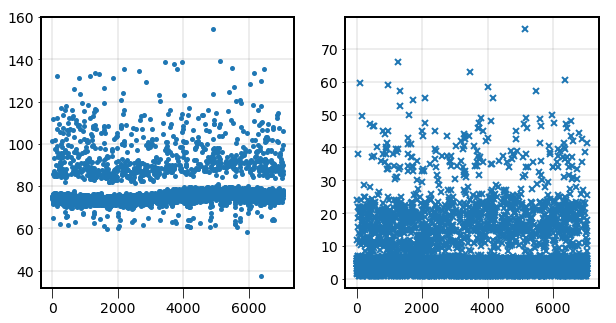

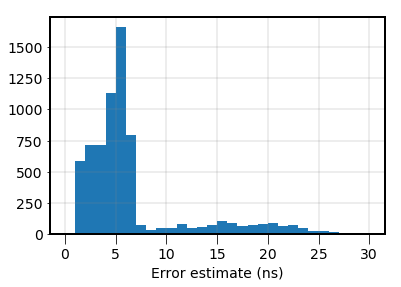

In [83]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.plot(data['delta_ts'][lbfit.pmtbool,0], '.')
fig.add_subplot(122)
plt.plot(lbfit.error[lbfit.pmtbool], 'x')
print 'PMTs used', np.sum(lbfit.pmtbool)

plt.figure()
_ = plt.hist(lbfit.error[lbfit.pmtbool], np.linspace(0, 30, 31))
plt.xlabel('Error estimate (ns)')

## Fitting with scipy

In [84]:
wrapfcn = lambda p: lbfit(*p)

In [85]:
fit = scipy.optimize.minimize(wrapfcn,
                              x0 = np.array([-100., 200., 100., 1.3]),
                              method='SLSQP',
                              bounds=((-4000,4000),
                                      (-4000,4000),
                                      (-4000,4000),
                                      (1., 1.5)),
                              options={'ftol':1E-7, 'maxiter':1000})

FCN 		 u 	 v 	 w 	 n
23911.2163787 	-100.0 	200.0 	100.0 	1.3
23911.2163787 	-100.0 	200.0 	100.0 	1.3
23911.2163786 	-99.9999999851 	200.0 	100.0 	1.3
23911.216379 	-100.0 	200.000000015 	100.0 	1.3
23911.2163787 	-100.0 	200.0 	100.000000015 	1.3
23911.2122168 	-100.0 	200.0 	100.0 	1.3000000149
58860.0364712 	-96.5178222656 	180.905029297 	98.5966796875 	1.5
15238.5608852 	-98.9262130522 	194.111750786 	99.5672630319 	1.36167329928
15238.5608852 	-98.9262130522 	194.111750786 	99.5672630319 	1.36167329928
15238.5608851 	-98.9262130373 	194.111750786 	99.5672630319 	1.36167329928
15238.5608854 	-98.9262130522 	194.1117508 	99.5672630319 	1.36167329928
15238.5608852 	-98.9262130522 	194.111750786 	99.5672630468 	1.36167329928
15238.56091 	-98.9262130522 	194.111750786 	99.5672630319 	1.36167331418
287960.184861 	671.061372221 	-4000.0 	-211.180604333 	1.33246056348
11340.2458376 	-15.7612788572 	-258.886498058 	66.0039609282 	1.35851808574
11340.2458376 	-15.7612788572 	-258.886498058

In [86]:
print fit

     fun: 11274.95442908772
     jac: array([ 0.        ,  0.        ,  0.        , -0.02575684])
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([  10.13264253, -234.5364568 ,   20.88501284,    1.35761228])


In [808]:
print fit

     fun: 8284.725919586923
     jac: array([ 0.        , -0.00012207, -0.00012207])
 message: 'Optimization terminated successfully.'
    nfev: 170
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([  32.18764938, -263.8727635 ,   46.74133181])


In [393]:
print 'DOF', np.sum(lbfit.pmtbool)

DOF 5308


In [815]:
print fit_pos
print manip_pos

[  -1.41507101 -219.31124878   21.13463783]
[   0. -254.   25.]


## Fitting with minuit

In [87]:
import iminuit

In [89]:
kwargs = {'u':data['fit_pos'][0],
          'v':data['fit_pos'][1],
          'w':data['fit_pos'][2],
          'n':1.3}

for one_key in kwargs.keys():
    kwargs['error_'+one_key] = 50.
    kwargs['limit_'+one_key] = (-1000., 1000.)
    
kwargs['error_n'] = 0.1
kwargs['limit_n'] = (1., 1.5)
    
kwargs['print_level'] = 0.
kwargs['errordef'] = 1.
   
fit = iminuit.Minuit(lbfit, **kwargs)

In [90]:
fit.migrad(ncall=1000)

18976.3000095 	3.82698130608 	-207.077072144 	24.7862033844 	1.3
18979.2975689 	7.19159168479 	-207.077072144 	24.7862033844 	1.3
18973.7800339 	0.46232760231 	-207.077072144 	24.7862033844 	1.3
18976.6842805 	4.29012461281 	-207.077072144 	24.7862033844 	1.3
18975.9247875 	3.36383717843 	-207.077072144 	24.7862033844 	1.3
18991.1213572 	3.82698130608 	-203.710955099 	24.7862033844 	1.3
18961.9004421 	3.82698130608 	-210.440739506 	24.7862033844 	1.3
18978.4445615 	3.82698130608 	-206.584177388 	24.7862033844 	1.3
18974.1645065 	3.82698130608 	-207.569914343 	24.7862033844 	1.3
18974.1132049 	3.82698130608 	-207.077072144 	28.1506984124 	1.3
18978.8383331 	3.82698130608 	-207.077072144 	21.4214275842 	1.3
18975.9254726 	3.82698130608 	-207.077072144 	25.3260417109 	1.3
18976.6835954 	3.82698130608 	-207.077072144 	24.2463578301 	1.3
17245.4192999 	3.82698130608 	-207.077072144 	24.7862033844 	1.30693900656
20939.7103106 	3.82698130608 	-207.077072144 	24.7862033844 	1.29302062669
18792

({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 4.1177202385908516e-06, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 11274.954433188836, 'nfcn': 80},
 [{'is_const': False, 'name': 'u', 'has_limits': True, 'value': 10.125291881104317, 'number': 0, 'has_lower_limit': True, 'upper_limit': 1000.0, 'lower_limit': -1000.0, 'has_upper_limit': True, 'error': 6.601185554112703, 'is_fixed': False},
  {'is_const': False, 'name': 'v', 'has_limits': True, 'value': -234.543629255753, 'number': 1, 'has_lower_limit': True, 'upper_limit': 1000.0, 'lower_limit': -1000.0, 'has_upper_limit': True, 'error': 7.179784038783566, 'is_fixed': False},
  {'is_const': False, 'name': 'w', 'has_limits': True, 'value': 20.88712206986429, 'number': 2, 'has_lower_limit': True, 'upper_limit': 1000.0, 'lower_limit': -1000.0, 'has_upper_limit': True

In [91]:
fit.hesse()

11274.9544332 	10.1252918811 	-234.543629256 	20.8871220699 	1.35761124064
11274.9570222 	10.4675636179 	-234.543629256 	20.8871220699 	1.35761124064
11274.9572345 	9.78301895797 	-234.543629256 	20.8871220699 	1.35761124064
11274.957103 	10.1252918811 	-234.171338051 	20.8871220699 	1.35761124064
11274.9572517 	10.1252918811 	-234.915886063 	20.8871220699 	1.35761124064
11274.9571583 	10.1252918811 	-234.543629256 	21.2861131788 	1.35761124064
11274.957096 	10.1252918811 	-234.543629256 	20.4881276344 	1.35761124064
11274.9570395 	10.1252918811 	-234.543629256 	20.8871220699 	1.35764590271
11274.9573327 	10.1252918811 	-234.543629256 	20.8871220699 	1.35757657604
11274.9544332 	10.1252918811 	-234.543629256 	20.8871220699 	1.35761124064
11274.9570222 	10.4675636179 	-234.543629256 	20.8871220699 	1.35761124064
11274.9572345 	9.78301895797 	-234.543629256 	20.8871220699 	1.35761124064
11274.957103 	10.1252918811 	-234.171338051 	20.8871220699 	1.35761124064
11274.9572517 	10.1252918811

[{'is_const': False, 'name': 'u', 'has_limits': True, 'value': 10.125291881104317, 'number': 0, 'has_lower_limit': True, 'upper_limit': 1000.0, 'lower_limit': -1000.0, 'has_upper_limit': True, 'error': 6.601185546477893, 'is_fixed': False},
 {'is_const': False, 'name': 'v', 'has_limits': True, 'value': -234.543629255753, 'number': 1, 'has_lower_limit': True, 'upper_limit': 1000.0, 'lower_limit': -1000.0, 'has_upper_limit': True, 'error': 7.179783820006435, 'is_fixed': False},
 {'is_const': False, 'name': 'w', 'has_limits': True, 'value': 20.88712206986429, 'number': 2, 'has_lower_limit': True, 'upper_limit': 1000.0, 'lower_limit': -1000.0, 'has_upper_limit': True, 'error': 7.695096012152646, 'is_fixed': False},
 {'is_const': False, 'name': 'n', 'has_limits': True, 'value': 1.3576112406431693, 'number': 3, 'has_lower_limit': True, 'upper_limit': 1.5, 'lower_limit': 1.0, 'has_upper_limit': True, 'error': 0.0006685325660411578, 'is_fixed': False}]

In [92]:
fit.print_matrix()

+,u,v,w,n
u,1.00,0.01,-0.03,0.04
v,0.01,1.00,0.00,0.14
w,-0.03,0.00,1.00,-0.04
n,0.04,0.14,-0.04,1.00


In [93]:
# Calculating the displacements wrt fit and manip

# MANIP
manip_dis = pmt_info['xyz']*manip_pos
manip_dcost = np.sum(manip_dis,axis=1)/pmt_r
manip_dcost_x = manip_dis[:,0]/pmt_r
manip_dcost_y = manip_dis[:,1]/pmt_r
manip_dcost_z = manip_dis[:,2]/pmt_r

# FIT
fit_dis = pmt_info['xyz']*fit_pos
fit_dcost = np.sum(fit_dis,axis=1)/pmt_r
fit_dcost_x = fit_dis[:,0]/pmt_r
fit_dcost_y = fit_dis[:,1]/pmt_r
fit_dcost_z = fit_dis[:,2]/pmt_r

# Myfit
myfit_dis = pmt_info['xyz']*myfit_pos
myfit_dcost = np.sum(myfit_dis,axis=1)/pmt_r
myfit_dcost_x = myfit_dis[:,0]/pmt_r
myfit_dcost_y = myfit_dis[:,1]/pmt_r
myfit_dcost_z = myfit_dis[:,2]/pmt_r


NameError: name 'manip_pos' is not defined

In [80]:
# Time differences
tdiff_manip = 2*R/water_c * (1+ manip_dcost/R)
tdiff_fit = 2*R/water_c * (1+ fit_dcost/R)
tdiff_myfit = 2*R/water_c * (1+myfit_dcost/R)

In [81]:
idelta = 0

(70, 80)

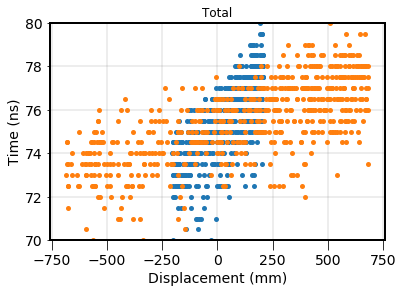

In [84]:
# Total displacement

#plt.plot(manip_dcost[pmtbool], tdiff_manip[pmtbool], 'x')
#plt.plot(fit_dcost[pmtbool], tdiff_fit[pmtbool], 'x')
plt.plot(fit_dcost[pmtbool], delta_ts[pmtbool,idelta], '.')
plt.plot(myfit_dcost[pmtbool], delta_ts[pmtbool,idelta], '.')

plt.title('Total')
plt.xlabel('Displacement (mm)')
plt.ylabel('Time (ns)')
plt.ylim([70, 80])

In [87]:
np.linalg.norm(myfit_pos)

688.56533084246291

(70, 80)

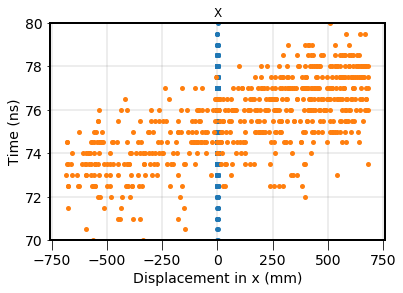

In [88]:
#plt.plot(manip_dcost_x[pmtbool], tdiff_manip[pmtbool], 'x')
#plt.plot(fit_dcost_x[pmtbool], tdiff_fit[pmtbool], '.')
plt.plot(fit_dcost_x[pmtbool], delta_ts[pmtbool,idelta], '.')
plt.plot(myfit_dcost[pmtbool], delta_ts[pmtbool,idelta], '.')

plt.title('X')
plt.xlabel('Displacement in x (mm)')
plt.ylabel('Time (ns)')
plt.ylim([70, 80])

(70, 80)

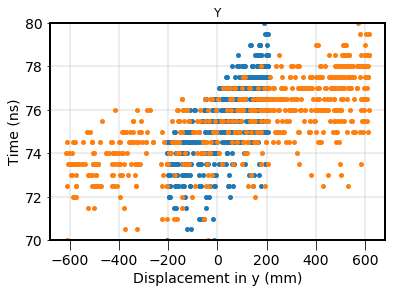

In [89]:
#plt.plot(manip_dcost_y[pmtbool], tdiff_manip[pmtbool], 'x')
#plt.plot(fit_dcost_y[pmtbool], tdiff_fit[pmtbool], '.')
plt.plot(fit_dcost_y[pmtbool], delta_ts[pmtbool,idelta], '.')
plt.plot(myfit_dcost_y[pmtbool], delta_ts[pmtbool,idelta], '.')

plt.title('Y')
plt.xlabel('Displacement in y (mm)')
plt.ylabel('Time (ns)')
plt.ylim([70, 80])

(70, 80)

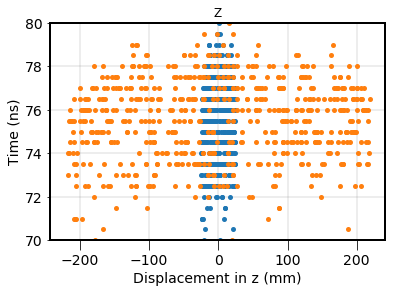

In [90]:
#plt.plot(manip_dcost_z[pmtbool], tdiff_manip[pmtbool], 'x')
#plt.plot(fit_dcost_z[pmtbool], tdiff_fit[pmtbool], '.')
plt.plot(fit_dcost_z[pmtbool], delta_ts[pmtbool,idelta], '.')
plt.plot(myfit_dcost_z[pmtbool], delta_ts[pmtbool,idelta], '.')

plt.title('Z')
plt.xlabel('Displacement in z (mm)')
plt.ylabel('Time (ns)')
plt.ylim([70, 80])

## Test part of the algorithm

In [477]:
reader = rat.socreader(infile_name)
soc, run = reader.next()
soc.GetRunID()
soc_pmts = np.array(soc.GetSOCPMTIDs())

In [478]:
time_array = np.array(soc.GetSOCPMT(120).GetTimes())
nbins = 600
twindow = [110, 220]

ybins  = np.linspace(0, 300, nbins+1)
smooth_coeff = 1./(ybins[1]-ybins[0])
n, x = np.histogram(time_array, ybins)
    
nsmooth = ndimage.filters.gaussian_filter1d(n, sigma=smooth_coeff)
nsmooth[nsmooth<=0] = 1

In [479]:
peaks = detect_peaks(nsmooth, mpd = 10*smooth_coeff,
                         edge='rising',show=False, mph=1.1)


In [480]:
time_array.size

8863

/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


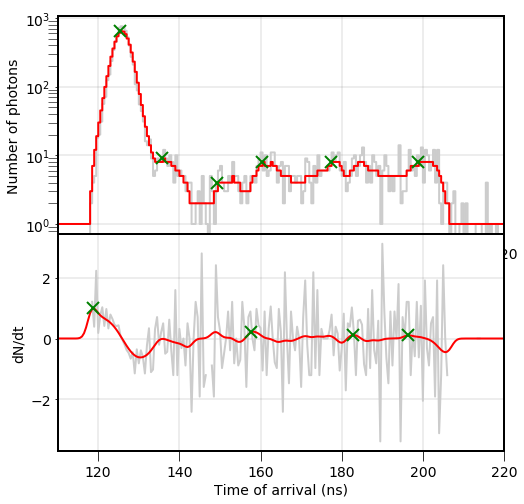

In [481]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
jplot.unfilledBar(ybins, n, color = '0.8')
jplot.unfilledBar(ybins, nsmooth, color='red')
plt.yscale('log')
plt.plot((ybins[peaks]+ybins[peaks-1])/2., 
         nsmooth[peaks], 'xg', markersize=12)
plt.xlim(twindow)
plt.ylabel('Number of photons')


    

dx = (ybins[1]-ybins[0])/2.
dn = np.diff(np.log10(n))/dx
dnsmooth = np.diff(np.log10(nsmooth))/dx  
# Smoothing over the derivative
dnsmooth = ndimage.filters.gaussian_filter1d(dnsmooth, 
                                         sigma=smooth_coeff)
ydn = ybins[1:-1]
peaks2 = detect_peaks(dnsmooth, mpd = 10*smooth_coeff,
                                 edge='rising',show=False, mph=0.1)

ax2 = fig.add_subplot(212,sharex=ax1)
plt.plot(ydn, dn, color = '0.8')

plt.plot(ydn, dnsmooth, color = 'red')
plt.subplots_adjust(hspace=0.)
plt.xlim(twindow)
plt.plot((ydn[peaks2]+ydn[peaks2-1])/2., 
          dnsmooth[peaks2], 'xg', markersize=12)
plt.ylabel('dN/dt')
plt.xlabel('Time of arrival (ns)')
plt.show()

In [506]:
time_array

array([ 204.71652222,  125.48567963,  128.57115173, ...,  135.47254944,
        183.67631531,  129.77758789])

In [507]:
getTimeDiff2(time_array, plot=True)

/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10


ValueError: attempt to get argmax of an empty sequence

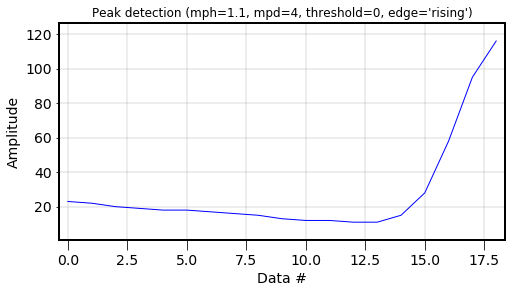

ValueError: attempt to get argmax of an empty sequence

In [647]:
plot = True

# Using the whole time window
ybins  = np.linspace(0, 300, int(300/bin_width)+1)
smooth_coeff = 1./bin_width
n, x = np.histogram(time_array, ybins)
nsmooth = ndimage.filters.gaussian_filter1d(n, sigma=smooth_coeff)
# Will use log(n) - zeros go away
nsmooth[nsmooth<=0] = 1
# Peak finding algorithm
peaks = detect_peaks(nsmooth, 
                     mpd = 10*smooth_coeff,
                     edge='rising',show=False, mph=1.1)
# Obtain the highest peak
highest_peak = peaks[nsmooth[peaks].argmax()]


# Do a histogram of late light only
ybins2 = np.linspace(ybins[highest_peak] + 55.,
                     ybins[highest_peak] + 55. + 20., 
                     int(20/bin_width/2.))
n, x = np.histogram(time_array, ybins2)
nsmooth2 = ndimage.filters.gaussian_filter1d(n, sigma=smooth_coeff/2.)
peaks2 = detect_peaks(nsmooth2, 
                     mpd = 2*smooth_coeff,
                     edge='rising',show=True, mph=1.1)
# Obtain the latest peak
latest_peak = peaks2[ybins2[peaks2].argmax()]

# Getting the time difference between highest ones
print latest_peak, highest_peak, ybins.shape, ybins2.shape
tdiff_peak = ybins2[latest_peak] - ybins[highest_peak]


# Finding the peaks of the derivative
dx = (ybins[1]-ybins[0])/2.
dn = np.diff(np.log10(n))/dx
ydn = ybins[1:-1]
ydn2 = ybins2[1:-1]

# Derivating, and smoothing over it
dnsmooth = np.diff(np.log10(nsmooth))/dx  
dnsmooth2 = np.diff(np.log10(nsmooth2))/dx
dnsmooth = ndimage.filters.gaussian_filter1d(dnsmooth, 
                                             sigma=smooth_coeff)
dnsmooth2 = ndimage.filters.gaussian_filter1d(dnsmooth2, 
                                             sigma=smooth_coeff/5.)
dpeaks = detect_peaks(dnsmooth, mpd = 10*smooth_coeff,
                      edge='rising',show=False, mph=0.1)
dpeaks2 = detect_peaks(dnsmooth2, mpd = 1.,
                      edge='rising',show=True, mph=0.01)

# Obtain the highest peak
highest_dpeak = dpeaks[dnsmooth[dpeaks].argmax()]
# Obtain the latest peak
latest_dpeak = dpeaks2[ydn2[dpeaks2].argmax()]
# Getting the time difference between highest ones
tdiff_dpeak = ydn2[latest_dpeak] - ydn[highest_dpeak]



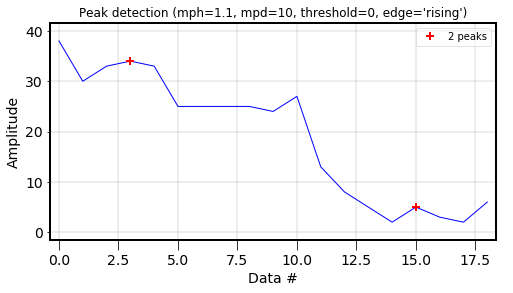

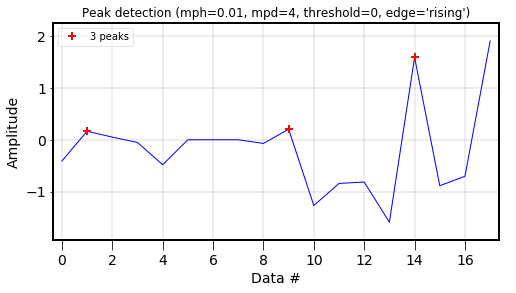

In [725]:
time_gap = 55.
# Using the whole time window
ybins  = np.linspace(0, 300, int(300/bin_width)+1)
smooth_coeff = 1./bin_width
n, x = np.histogram(time_array, ybins)
nsmooth = ndimage.filters.gaussian_filter1d(n, sigma=smooth_coeff)
# Will use log(n) - zeros go away
nsmooth[nsmooth<=0] = 1
# Peak finding algorithm
peaks = detect_peaks(nsmooth, 
                     mpd = 10*smooth_coeff,
                     edge='rising',show=False, mph=1.1)
# Obtain the highest peak
highest_peak = peaks[nsmooth[peaks].argmax()]


# Do a histogram of late light only
ybins2 = np.linspace(ybins[highest_peak] + time_gap,
                     ybins[highest_peak] + time_gap + 40., 
                     int(20/bin_width/2.))
n, x = np.histogram(time_array, ybins2)
nsmooth2 = ndimage.filters.gaussian_filter1d(n, sigma=smooth_coeff/5.)
peaks2 = detect_peaks(nsmooth2, 
                     mpd = 5*smooth_coeff,
                     edge='rising',show=True, mph=1.1)
# Obtain the latest peak
latest_peak = peaks2[ybins2[peaks2].argmax()]


# Getting the time difference between highest ones
if peaks.size !=0 or peaks2.size !=0:
    tdiff_peak = ybins2[latest_peak] - ybins[highest_peak]
else:
    print peaks, peaks2
    tdiff_peak = -1


# Finding the peaks of the derivative
dx = (ybins[1]-ybins[0])/2.
dn = np.diff(np.log10(n))/dx
ydn = ybins[1:-1]
ydn2 = ybins2[1:-1]

# Derivating, and smoothing over it
dnsmooth = np.diff(np.log10(nsmooth))/dx  
dnsmooth2 = np.diff(np.log10(nsmooth2))/dx
dnsmooth = ndimage.filters.gaussian_filter1d(dnsmooth, 
                                             sigma=smooth_coeff)
dnsmooth2 = ndimage.filters.gaussian_filter1d(dnsmooth2, 
                                             sigma=smooth_coeff/10.)
dpeaks = detect_peaks(dnsmooth, mpd = 10*smooth_coeff,
                      edge='rising',show=False, mph=0.1)
dpeaks2 = detect_peaks(dnsmooth2, mpd = 2*smooth_coeff,
                      edge='rising',show=True, mph=0.01)

# Obtain the highest peak
highest_dpeak = dpeaks[dnsmooth[dpeaks].argmax()]
# Obtain the latest peak
latest_dpeak = dpeaks2[ydn2[dpeaks2].argmax()]
# Getting the time difference between highest ones
if dpeaks.size !=0 or dpeaks2.size !=0:
    tdiff_dpeak = ydn2[latest_dpeak] - ydn[highest_dpeak]
else:
    print peaks, peaks2
    tdiff_dpeak = -1

In [886]:
pmt_info['type'].size

9728